

# **Love nearest neighbors: sentiment analysis using nearest neighbors and efficient combination of deep model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import keras.backend as K

In [ ]:
from sklearn.metrics import normalized_mutual_info_score,f1_score,precision_score,recall_score, adjusted_rand_score, accuracy_score, homogeneity_score, adjusted_mutual_info_score, silhouette_score

nmi_fun = normalized_mutual_info_score
ari_fun = adjusted_rand_score
ami_fun = adjusted_mutual_info_score
silhouette_score_fun = silhouette_score
f1_score_fun = f1_score
precision_score_fun = precision_score
recall_score_fun = recall_score

# acc_fun = homogeneity_score

def acc_fun (y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed

    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`

    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = list(linear_assignment(w.max() - w))
    acc_sum = 0
    for k in range(len(w)):
       acc_sum =  w[ind[0][k],ind[1][k]] + acc_sum
    return acc_sum * 1.0 / y_pred.size

In [ ]:
from time import time
import keras.backend as K
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input, Reshape
from keras.models import Model
from sklearn.feature_extraction.text import TfidfVectorizer
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans, MiniBatchKMeans,k_means
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize
import networkx as nx
import numpy as np
import glob
import os, os.path
import math
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
np.random.seed(10)

In [ ]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/BGETTY/shuffled_BGETTY_DATASET.csv')

for i in range(len(df)):
  if df['label'][i] == 'Positive':
    df['label'][i] = 1
  else:
    df['label'][i] = 0


df = df.sample(frac = 1,ignore_index=True)
df_train = df[0:len(df)*80//100]     #80%
df_test = df[len(df)*80//100:]       #20%

y_train = np.asarray(df_train['label']).astype(int)
y_test = np.asarray(df_test['label']).astype(int)

In [ ]:
def image_neighbor_select(idx, df_set = 'train'):
    simi = np.zeros([len(idx), len(idx)])
    neighbor_idx = np.zeros([len(idx), 2])

    for i in range(len(idx)):
      for j in range(len(idx)):
        if df_set == 'train':
          a = set(df_train['text'][i].split())
          b = set(df_train['text'][j].split())
        else:
          a = set(df_test['text'][i + df_test['text'].index.start].split())
          b = set(df_test['text'][j + df_test['text'].index.start].split())          

        if  (df_set == 'train') and (i==j or (df_train['label'][i] != df_train['label'][j])):
          simi[i,j] = 0
        elif (df_set != 'train') and (i==j or (df_test['label'][i + df_test['label'].index.start] != df_test['label'][j + df_test['label'].index.start])):
          simi[i,j] = 0
        else:
          simi[i,j] = len(a.intersection(b)) / len(a.union(b))
      

      neighbor_idx[i,0], neighbor_idx[i,1] = np.argpartition(simi[i], -2)[-2:]

    return neighbor_idx.astype(int)

In [ ]:
df['text'].apply(lambda x:len(x)).describe()

count    20127.000000
mean        96.088190
std         57.669424
min          4.000000
25%         56.000000
50%         84.000000
75%        126.000000
max       1491.000000
Name: text, dtype: float64

In [ ]:
all_word = df['text'].apply(lambda x: x.split()).values

In [ ]:
empty_list = []
for word_list in all_word:
  empty_list.extend(word_list)

len(empty_list)

271077

In [ ]:
len(set(empty_list))

15573

#text

In [ ]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 200  # We will cut reviews after 100 words
training_samples = df_train.index.size 
max_words = 10000  # We will only consider the top 10,000 words in the dataset

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['text'])
sequences = tokenizer.texts_to_sequences(df_train['text'])

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data_txt = pad_sequences(sequences, maxlen=maxlen)
print('Shape of data tensor:', data_txt.shape)

Found 11781 unique tokens.
Shape of data tensor: (16101, 200)


In [ ]:
indices = np.arange(data_txt.shape[0])
data_txt = data_txt[indices]
x_train = data_txt

In [ ]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!pip install unzip
!unzip -q glove.6B.zip

--2023-03-09 10:34:40--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2023-03-09 10:37:19 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for unzip: filename=unzip-1.0.0-py3-none-any.whl size=1322 sha256=d994fe167eca3cff220d3acdd1c6b71e7b83cc74a227eb58aea46f9eab4df2b6
  Stored in directory: /root/.cache/pip/wheels/88/2c/2b/d12ab5bb9f34eba42f98231b969311f33d7dc1a2f484b902d1
Successfully built unzip


In [ ]:
embeddings_index = {}
f = open(os.path.join('glove.6B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 200

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Concatenate, GRU
from keras import models
from keras import layers
import keras

max_features = 10000
input_shape = 200

BiLSTM_1 = Sequential()
BiLSTM_1.add(Embedding(max_features, 128))
BiLSTM_1.add(Bidirectional(LSTM(128, return_sequences=True)))
BiLSTM_1.add(Bidirectional(LSTM(64, return_sequences=True)))
BiLSTM_1.add(LSTM(64))

BiLSTM_2 = Sequential()
BiLSTM_2.add(Embedding(max_features, 128))
BiLSTM_2.add(GRU(128, return_sequences=True))
BiLSTM_2.add(GRU(64, return_sequences=True))
BiLSTM_2.add(LSTM(64))

input_text = keras.Input(shape=(input_shape), name='input_text_')
x1 = BiLSTM_1(input_text)
x2 = BiLSTM_2(input_text)

out_encoder = layers.Maximum()([x1, x2])

input_textNeighbor1 = keras.Input(shape=(input_shape), name='input_textNeighbor1')
Neighbor1 = BiLSTM_1(input_textNeighbor1)

input_textNeighbor2 = keras.Input(shape=(input_shape), name='input_textNeighbor2')
Neighbor2 = BiLSTM_2(input_textNeighbor2)

out_encoder_neighbor = layers.Maximum()([Neighbor1,Neighbor2])
out_con = Concatenate(axis=1)([out_encoder, out_encoder_neighbor])

encoded = layers.Dense(128, activation='relu')(out_con)
encoded = layers.Dropout(0.25)(encoded)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dropout(0.25)(encoded)
encoded = layers.Dense(32, activation='relu')(encoded) # before 16
encoded = layers.Dense(1, activation='sigmoid')(encoded)

encoderWithNeighbors = keras.Model(inputs=[input_text, input_textNeighbor1, input_textNeighbor2], outputs=encoded, name='encoder')  

In [ ]:
encoderWithNeighbors.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_text_ (InputLayer)       [(None, 200)]        0           []                               
                                                                                                  
 input_textNeighbor1 (InputLaye  [(None, 200)]       0           []                               
 r)                                                                                               
                                                                                                  
 input_textNeighbor2 (InputLaye  [(None, 200)]       0           []                               
 r)                                                                                               
                                                                                            

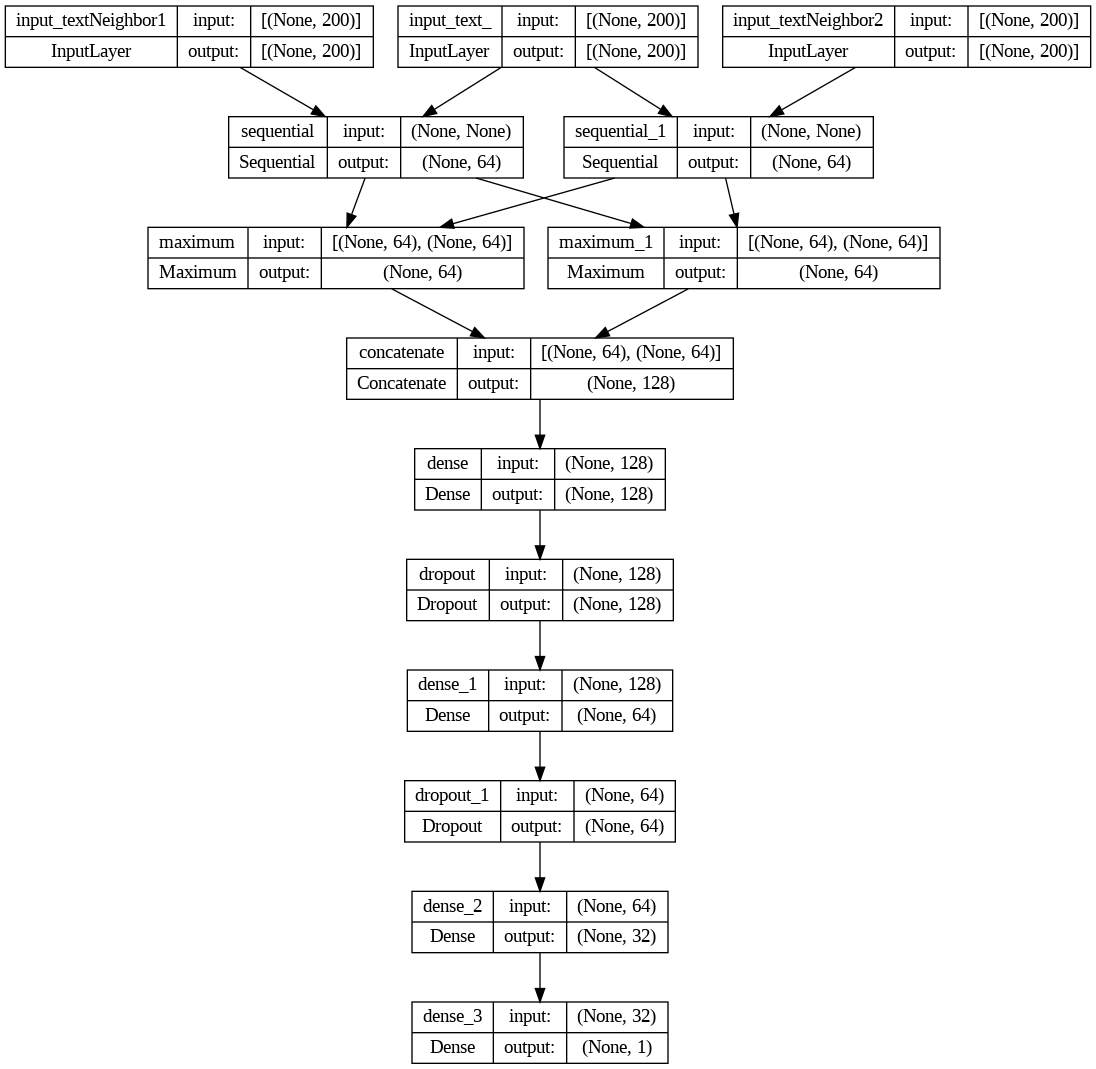

In [ ]:
import tensorflow
from keras import optimizers
tensorflow.keras.utils.plot_model(encoderWithNeighbors, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
epoch = 3 # before 2
batch_size = 32 # before 64
maxiter = df_train.index.size // batch_size * epoch
update_interval = 100
loss = 0
index = 0
save_dir = '/content/drive/MyDrive/'
index_array = np.arange(df_train.index.size )

In [ ]:
encoderWithNeighbors.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])

In [ ]:
for ite in range(int(maxiter)):
    idx = index_array[index * batch_size: min((index+1) * batch_size, df_train.index.size)]
    neighbor_idx = image_neighbor_select(idx)

    loss = encoderWithNeighbors.train_on_batch(x=[x_train[idx],x_train[neighbor_idx[:,0]],x_train[neighbor_idx[:,1]]], y = y_train[idx].astype(int))

    loss = np.round(loss, 5)
    if (ite%5 == 0):
      print('Iter %d: ' % (ite), ' ; loss=', loss[0], '; Accuracy=', loss[1])
      encoderWithNeighbors.save_weights(save_dir + '/texts_BGETTY_DATASET_v2.h5')

    index = index + 1 if (index + 1) * batch_size <= df_train.index.size  else 0

encoderWithNeighbors.save_weights(save_dir + '/texts_BGETTY_DATASET_v2.h5')

Iter 0:   ; loss= 1.31983 ; Accuracy= 0.53125
Iter 5:   ; loss= 0.48774 ; Accuracy= 0.5
Iter 10:   ; loss= 0.28564 ; Accuracy= 0.9375
Iter 15:   ; loss= 0.19554 ; Accuracy= 1.0
Iter 20:   ; loss= 0.07869 ; Accuracy= 1.0
Iter 25:   ; loss= 0.04737 ; Accuracy= 1.0
Iter 30:   ; loss= 0.01339 ; Accuracy= 1.0
Iter 35:   ; loss= 0.00414 ; Accuracy= 1.0
Iter 40:   ; loss= 0.03398 ; Accuracy= 0.96875
Iter 45:   ; loss= 0.00123 ; Accuracy= 1.0
Iter 50:   ; loss= 0.00046 ; Accuracy= 1.0
Iter 55:   ; loss= 0.00065 ; Accuracy= 1.0
Iter 60:   ; loss= 0.00054 ; Accuracy= 1.0
Iter 65:   ; loss= 0.14042 ; Accuracy= 0.96875
Iter 70:   ; loss= 0.00922 ; Accuracy= 1.0
Iter 75:   ; loss= 0.05849 ; Accuracy= 0.96875
Iter 80:   ; loss= 0.00157 ; Accuracy= 1.0
Iter 85:   ; loss= 0.00087 ; Accuracy= 1.0
Iter 90:   ; loss= 0.00114 ; Accuracy= 1.0
Iter 95:   ; loss= 0.00019 ; Accuracy= 1.0
Iter 100:   ; loss= 0.00169 ; Accuracy= 1.0
Iter 105:   ; loss= 0.00147 ; Accuracy= 1.0
Iter 110:   ; loss= 0.00189 ; Accur

In [ ]:
encoderWithNeighbors.load_weights(save_dir + '/texts_BGETTY_DATASET_v2.h5')

In [ ]:
flag=True
y_pred = np.zeros([df_train.index.size,1])
index = 0
index_array = np.arange(df_train.index.size )
label_txt = np.zeros([df_train.index.size])

while flag==True:
  
    idx = index_array[index * batch_size: min((index+1) * batch_size, df_train.index.size)]
    neighbor_idx = image_neighbor_select(idx)
    label_txt[idx] = y_train[idx]

    y_pred[idx] = encoderWithNeighbors.predict([x_train[idx], x_train[neighbor_idx[:,0]],x_train[neighbor_idx[:,1]]], verbose=0)

    if (index + 1) * batch_size <= df_train.index.size:
      index = index + 1 
    else:
      flag = False

y_pred = np.round(np.reshape(y_pred, df_train.index.size)).astype(int)

acc = np.round(acc_fun(y_train, y_pred), 5)
recall = np.round(recall_score(y_train, y_pred), 5)
f1 = np.round(f1_score_fun(y_train, y_pred), 5)
precision =np.round(precision_score_fun(y_train, y_pred), 5)

print('acc = %.5f, recall = %.5f, f1 = %.5f, precision = %.5f' % (acc, recall, f1, precision))

acc = 0.99975, recall = 0.99975, f1 = 0.99975, precision = 0.99975


In [ ]:
sequences = tokenizer.texts_to_sequences(df_test['text'])
x_test = pad_sequences(sequences, maxlen=maxlen)

In [ ]:
flag=True
y_pred = np.zeros([df_test.index.size,1])
index = 0
index_array = np.arange(df_test.index.size )
label_txt = np.zeros([df_test.index.size])

while flag==True:
  
    idx = index_array[index * batch_size: min((index+1) * batch_size, df_test.index.size)]
    neighbor_idx = image_neighbor_select(idx, df_set='test')

    y_pred[idx] = encoderWithNeighbors.predict([x_test[idx], x_test[neighbor_idx[:,0]],x_test[neighbor_idx[:,1]]], verbose=0)

    if (index + 1) * batch_size <= df_test.index.size:
      index = index + 1 
    else:
      flag = False

y_pred = np.round(np.reshape(y_pred, df_test.index.size)).astype(int)

acc = np.round(acc_fun(y_test, y_pred), 5)
recall = np.round(recall_score(y_test, y_pred), 5)
f1 = np.round(f1_score_fun(y_test, y_pred), 5)
precision =np.round(precision_score_fun(y_test, y_pred), 5)

print('acc = %.5f, recall = %.5f, f1 = %.5f, precision = %.5f' % (acc, recall, f1, precision))

acc = 0.99603, recall = 0.99652, f1 = 0.99603, precision = 0.99553
